<a href="https://colab.research.google.com/github/zxcej/COMP691_LABS/blob/main/Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1

Use the below model for **1 (a) - (c)**

100%|██████████| 9912422/9912422 [00:00<00:00, 60421821.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7553042.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25204145.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19885729.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182040794/182040794 [00:04<00:00, 40220752.22it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 31311353.16it/s]


Training MNIST classifier
Epoch: 1/20, Train Loss: 0.2873, Test Acc: 0.9764
Epoch: 2/20, Train Loss: 0.0496, Test Acc: 0.9860
Epoch: 3/20, Train Loss: 0.0343, Test Acc: 0.9844
Epoch: 4/20, Train Loss: 0.0267, Test Acc: 0.9820
Epoch: 5/20, Train Loss: 0.0232, Test Acc: 0.9806
Epoch: 6/20, Train Loss: 0.0204, Test Acc: 0.9904
Epoch: 7/20, Train Loss: 0.0178, Test Acc: 0.9827
Epoch: 8/20, Train Loss: 0.0160, Test Acc: 0.9877
Epoch: 9/20, Train Loss: 0.0138, Test Acc: 0.9891
Epoch: 10/20, Train Loss: 0.0126, Test Acc: 0.9909
Epoch: 11/20, Train Loss: 0.0113, Test Acc: 0.9916
Epoch: 12/20, Train Loss: 0.0094, Test Acc: 0.9918
Epoch: 13/20, Train Loss: 0.0094, Test Acc: 0.9912
Epoch: 14/20, Train Loss: 0.0087, Test Acc: 0.9916
Epoch: 15/20, Train Loss: 0.0080, Test Acc: 0.9901
Epoch: 16/20, Train Loss: 0.0061, Test Acc: 0.9909
Epoch: 17/20, Train Loss: 0.0076, Test Acc: 0.9927
Epoch: 18/20, Train Loss: 0.0065, Test Acc: 0.9922
Epoch: 19/20, Train Loss: 0.0056, Test Acc: 0.9900
Epoch: 20/20, 

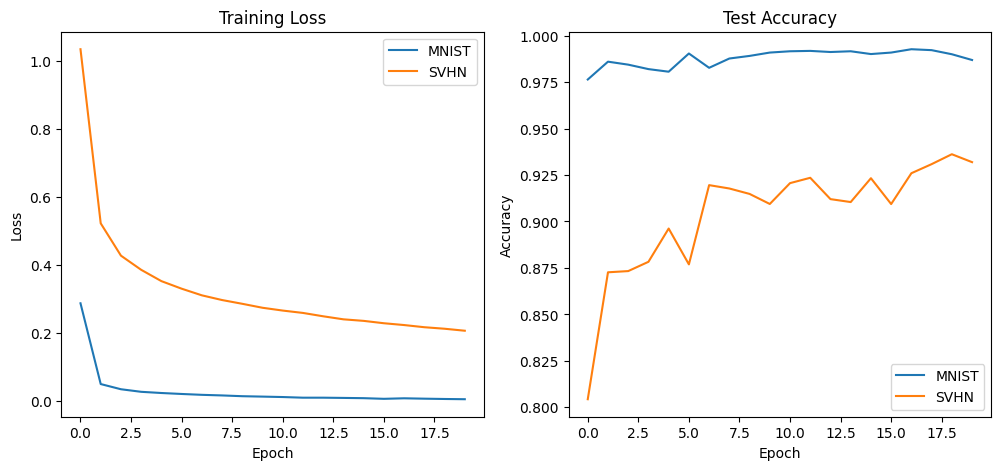

Final test accuracy for MNIST: 0.9869
Final test accuracy for SVHN: 0.9319


In [1]:
import torch.nn as nn

feature_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), 
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

# For (b)-(c) add the task heads on top of the feature_model
# Note this model can adapt the averaging to the size so inputs of 32x32 and 28x28 both work
# Grayscale conversion for SVHN, you may use transforms.Grayscale(num_output_channels=1) found in torchvision

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np

# Load the data
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

svhn_train_gray = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform= transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
svhn_test_gray = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform= transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))

# #show some images
# def show_images(images, labels):
#     plt.figure(figsize=(10, 10))
#     for i in range(25):
#         plt.subplot(5, 5, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(np.transpose(images[i], (1, 2, 0)))
#         plt.xlabel(labels[i])
#     plt.show()

# random_indices = np.random.randint(0, len(mnist_train), 25)
# show_images([svhn_train[i][0] for i in random_indices], [svhn_train[i][1] for i in random_indices])

batch_size = 128
learning_rate = 0.001
num_epochs = 20

# Create the dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

svhn_train_loader = DataLoader(svhn_train_gray, batch_size=batch_size, shuffle=True)
svhn_test_loader = DataLoader(svhn_test_gray, batch_size=batch_size, shuffle=False)


class Classifier(nn.Module):
    def __init__(self, feature_model, num_classes):
        super(Classifier, self).__init__()
        self.feature_model = feature_model
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.feature_model(x)
        x = self.classifier(x)
        return x
    

# Train and evaluate functions

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

def train_and_evaluate(model, train_loader, test_loader, device, num_epochs, learning_rate):
    train_loss_arr = []
    test_acc_arr = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_acc = evaluate(model, test_loader, device)
        train_loss_arr.append(train_loss)
        test_acc_arr.append(test_acc)
        print('Epoch: {}/{}, Train Loss: {:.4f}, Test Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, test_acc))
    return train_loss_arr, test_acc_arr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Train MNIST classifier
print ('Training MNIST classifier')
mnist_classifier = Classifier(feature_model, 10).to(device)
mnist_train_loss_arr, mnist_test_acc_arr = train_and_evaluate(mnist_classifier, mnist_train_loader, mnist_test_loader, device, num_epochs, learning_rate)

#Train SVHN classifier
print ('Training SVHN classifier')
svhn_classifier = Classifier(feature_model, 10).to(device)
svhn_train_loss_arr, svhn_test_acc_arr = train_and_evaluate(svhn_classifier, svhn_train_loader, svhn_test_loader, device, num_epochs, learning_rate)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mnist_train_loss_arr, label='MNIST')
plt.plot(svhn_train_loss_arr, label='SVHN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(mnist_test_acc_arr, label='MNIST')
plt.plot(svhn_test_acc_arr, label='SVHN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy')

plt.show()


print(f"Final test accuracy for MNIST: {mnist_test_acc_arr[-1]:.4f}")
print(f"Final test accuracy for SVHN: {svhn_test_acc_arr[-1]:.4f}")






### **Question** **1 (c)**

Traning and evaluating multi-task model...
Epoch: 1/20, Train Loss: 0.3196, MNIST Test Acc: 0.9590, SVHN Test Acc: 0.8992
Epoch: 2/20, Train Loss: 0.1827, MNIST Test Acc: 0.9470, SVHN Test Acc: 0.9157
Epoch: 3/20, Train Loss: 0.1666, MNIST Test Acc: 0.9561, SVHN Test Acc: 0.9264
Epoch: 4/20, Train Loss: 0.1578, MNIST Test Acc: 0.9166, SVHN Test Acc: 0.9064
Epoch: 5/20, Train Loss: 0.1510, MNIST Test Acc: 0.9532, SVHN Test Acc: 0.9335
Epoch: 6/20, Train Loss: 0.1452, MNIST Test Acc: 0.9295, SVHN Test Acc: 0.9290
Epoch: 7/20, Train Loss: 0.1393, MNIST Test Acc: 0.9576, SVHN Test Acc: 0.9224
Epoch: 8/20, Train Loss: 0.1342, MNIST Test Acc: 0.9445, SVHN Test Acc: 0.9299
Epoch: 9/20, Train Loss: 0.1323, MNIST Test Acc: 0.8953, SVHN Test Acc: 0.9274
Epoch: 10/20, Train Loss: 0.1278, MNIST Test Acc: 0.9424, SVHN Test Acc: 0.9267
Epoch: 11/20, Train Loss: 0.1222, MNIST Test Acc: 0.9365, SVHN Test Acc: 0.9167
Epoch: 12/20, Train Loss: 0.1193, MNIST Test Acc: 0.9257, SVHN Test Acc: 0.9309
Epoch:

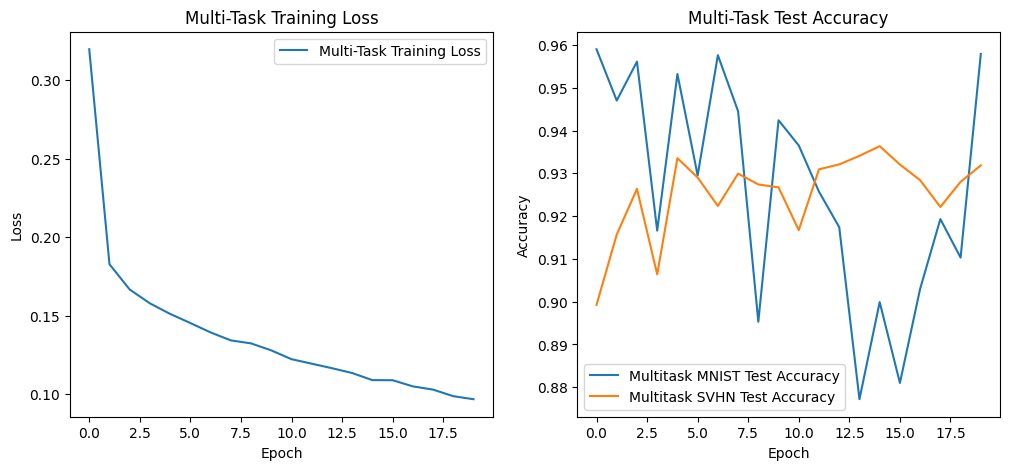

Final multitask test accuracy for MNIST: 0.9579
Final multitask test accuracy for SVHN: 0.9319


In [2]:
#Write a multi-task learning model

import itertools

class MultiTaskClassifier(nn.Module):
    def __init__(self, feature_model, num_classes):
        super(MultiTaskClassifier, self).__init__()
        self.feature_model = feature_model
        self.head_mnist = nn.Sequential(
            nn.Linear(64,64), nn.ReLU(), nn.Linear(64, num_classes)
        )
        self.head_svhn = nn.Sequential(
            nn.Linear(64,64), nn.ReLU(), nn.Linear(64, num_classes)
        )

    def forward(self, x, task):
        x = self.feature_model(x)
        if task == 'mnist':
            x = self.head_mnist(x)
        elif task == 'svhn':
            x = self.head_svhn(x)
        return x
    
# Train and evaluate functions

def multi_task_train(model, mnist_dataloader, svhn_dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for mnist_tuple, svhn_tuple in itertools.zip_longest(mnist_dataloader, svhn_dataloader):
        if mnist_tuple is not None:
            mnist_data, mnist_target = mnist_tuple
            mnist_data, mnist_target = mnist_data.to(device), mnist_target.to(device)
            optimizer.zero_grad()
            mnist_output = model(mnist_data, 'mnist')
            mnist_loss = criterion(mnist_output, mnist_target)
            mnist_loss.backward()
            optimizer.step()
            running_loss += mnist_loss.item() * mnist_data.size(0)
    
        if svhn_tuple is not None:
            svhn_data, svhn_target = svhn_tuple
            svhn_data, svhn_target = svhn_data.to(device), svhn_target.to(device)
            optimizer.zero_grad()
            svhn_output = model(svhn_data, 'svhn')
            svhn_loss = criterion(svhn_output, svhn_target)
            svhn_loss.backward()
            optimizer.step()
            running_loss += svhn_loss.item() * svhn_data.size(0)
            
    return running_loss / (len(mnist_dataloader.dataset) + len(svhn_dataloader.dataset))

def multi_task_evaluate(model, mnist_dataloader, svhn_dataloader, device):
    model.eval()
    mnist_correct = 0
    mnist_total = 0
    svhn_correct = 0
    svhn_total = 0
    with torch.no_grad():
        for mnist_tuple, svhn_tuple in itertools.zip_longest(mnist_dataloader, svhn_dataloader):
            if mnist_tuple is not None:
                mnist_data, mnist_target = mnist_tuple
                mnist_data, mnist_target = mnist_data.to(device), mnist_target.to(device)
                mnist_output = model(mnist_data, 'mnist')
                _, mnist_pred = torch.max(mnist_output, 1)
                mnist_correct += (mnist_pred == mnist_target).sum().item()
                mnist_total += mnist_target.size(0)
            
            if svhn_tuple is not None:
                svhn_data, svhn_target = svhn_tuple
                svhn_data, svhn_target = svhn_data.to(device), svhn_target.to(device)
                svhn_output = model(svhn_data, 'svhn')
                _, svhn_pred = torch.max(svhn_output, 1)
                svhn_correct += (svhn_pred == svhn_target).sum().item()
                svhn_total += svhn_target.size(0)

    mnist_acc = mnist_correct / mnist_total
    svhn_acc = svhn_correct / svhn_total
    return mnist_acc, svhn_acc

def multi_task_train_and_evaluate(model, mnist_train_loader, mnist_test_loader, svhn_train_loader, svhn_test_loader, device, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr = []
    mnist_test_acc_arr = []
    svhn_test_acc_arr = []
    for epoch in range(num_epochs):
        train_loss = multi_task_train(model, mnist_train_loader, svhn_train_loader, criterion, optimizer, device)
        mnist_test_acc, svhn_test_acc = multi_task_evaluate(model, mnist_test_loader, svhn_test_loader, device)
        train_loss_arr.append(train_loss)
        mnist_test_acc_arr.append(mnist_test_acc)
        svhn_test_acc_arr.append(svhn_test_acc)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, MNIST Test Acc: {mnist_test_acc:.4f}, SVHN Test Acc: {svhn_test_acc:.4f}")
    return train_loss_arr, mnist_test_acc_arr, svhn_test_acc_arr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64

mnist_train_half_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_half_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
svhn_train_half_loader = DataLoader(svhn_train_gray, batch_size=batch_size, shuffle=True)
svhn_test_half_loader = DataLoader(svhn_test_gray, batch_size=batch_size, shuffle=False)



print("Traning and evaluating multi-task model...")
multitask_model = MultiTaskClassifier(feature_model, num_classes=10).to(device)
multitask_loss_arr, multitask_mnist_test_acc_arr, multitask_svhn_test_acc_arr = multi_task_train_and_evaluate(multitask_model, mnist_train_half_loader, mnist_test_half_loader, svhn_train_half_loader, svhn_test_half_loader, device, num_epochs, learning_rate)

# Plot the training loss and test accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(multitask_loss_arr, label='Multi-Task Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Multi-Task Training Loss')

plt.subplot(1,2,2)
plt.plot(multitask_mnist_test_acc_arr, label='Multitask MNIST Test Accuracy')
plt.plot(multitask_svhn_test_acc_arr, label='Multitask SVHN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Multi-Task Test Accuracy')
plt.show()


print(f"Final multitask test accuracy for MNIST: {multitask_mnist_test_acc_arr[-1]:.4f}")
print(f"Final multitask test accuracy for SVHN: {multitask_svhn_test_acc_arr[-1]:.4f}")








    



### **Question** **1 (d)**

In this question we will train a joint embedding between a model embedding from MNIST and a model embedding from SVHN dataset, both digit datasets. Your specific task to evaluate this will be to try to obtain $70\%$ or higher accuracy on the MNIST classification by embedding MNIST test digits and then searching for the 1-nearest neighbor SVHN digit and using it's category to classify.  

First we will define the mnist and svhn models. For svhn we will use a pre-trained model that can already classify svhn digits. The models are defined below 

In [3]:
## MNIST model
model_mnist = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), #For (e) use SVHN nn.Conv2d(3,32,5)
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

from torch.utils import model_zoo
from collections import OrderedDict
### SVHN model, we will download one that is already trained to clasify svhn digits
model_urls = {
    'svhn': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth',
}

class SVHN(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(SVHN, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features

        #We won't use this classifier
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        print(self.features)
        print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU(), nn.Dropout(0.3)]
            else:
                layers += [conv2d, nn.ReLU(), nn.Dropout(0.3)]
            in_channels = out_channels
    return nn.Sequential(*layers)

def svhn_model(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = SVHN(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['svhn'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)

    return model


base_svhn = svhn_model(n_channel=32,pretrained=True).features
svhn_to_joint = nn.Linear(256,64)

model_svhn = nn.Sequential(base_svhn, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), svhn_to_joint)


#Transformation for SVHN data, you need to use this normalization for the pre-trained model to work properly 
transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.3, inplace=False)
  (17): MaxPool2d(kernel_size=2, stride=2, padding=0

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth" to /root/.cache/torch/hub/checkpoints/svhn-f564f3d8.pth
100%|██████████| 2.24M/2.24M [00:01<00:00, 1.58MB/s]


Let's denote model_mnist above as $f_{\theta}(x)$, the pre_trained model $g_{\gamma}$ and svhn_to_joint as the matrix $W$. Finally model_svhn corresponds to $WAg_{\gamma}(x)$. Here A (nn.AdaptiveAvgPool2d) is the averaging operator and has no parameters. Thus model_svhn will map svhn digits to a joint space and model_mnist will map MNIST digits to the joint space.  We will keep $g_{
\gamma}$ fixed and update $\theta, W$.  You should optimize the following objective that is a sum of two loss functions over triplets


$$\min_{\theta, W} \sum_{x_a,x_p,x_n \in \textbf{M}} max(0, \|f_{\theta}(x_a) - WAg_{\gamma}(x_p) \|-\|f_{\theta}(x_a) - WAg_{\gamma}(x_n) \|+\alpha) +\sum_{x_a,x_p,x_n \in \textbf{S}} max(0, \|f_{\theta}(x_p) - WAg_{\gamma}(x_a) \|-\|f_{\theta}(x_n) - WAg_{\gamma}(x_a) \|+\alpha)$$ 


Here $\textbf{M}$ is the set of triplets with anchors from MNIST data, positives from SVHN (matching the anchor class), and negatives from SVHN (with different class from anchors). Similarly $\textbf{S}$ is the set of triplets with anchors from SVHN data, positives from MNIST (matching anchor class), and negatives from MNIST not matching anchor class. You can use nn.TripletMarginLoss to implement this.  

During training with a stochastic optimizer we will sample subsets of $M$ and $S$ for each gradient update, there are various valid ways to sample this as will be discussed.

Note we only optimize W and $\theta$, below see an example how to build the optimizer. Note we want to freeze the $g_{\gamma}$ model so we will also need to disable the dropout and batchnorm. 

In [4]:
from torch import optim
optimizer = optim.Adam(list(model_mnist.parameters()) + list(svhn_to_joint.parameters()), lr=1e-5) # you may experiment with different learning rates
model_svhn.eval() #IMPORTANT: BEFORE running set to eval even for training to avoid dropout, we want to keep this fixed except the final layer, otherwise training will need to be much longer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.3, inplace=False)

**Suggested settings:** learning rate 1e-5 with Adam, margin ($\alpha$) of 0.2, batch size: 256 triplets samples $M$ and 256 from $S$, 1000 training iterations (not epochs, but gradient updates/minibatch processed, aka it can be trained fast!). You may modify these as you see fit.

Data augmentation is not required to make this work but you may use it if you like. For SVHN you must use the normalization above (transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))) so that the pre-trained SVHN model works. 

**Sampling the triplets** There are various valid ways you could construct the triplet sets $\textbf{M, S}$ and sample from them. For example you could enumerate all possible triplets over the dataset and select batches of these. A quick and dirty on the fly method that allows to use standard dataloaders is as follows: Sample a minibatch of size N (say 256) from both SVHN and MNIST using standard dataloaders from classification tasks. Treat all SVHN digits in this batch as  anchors, from the MNIST minibatch data find appropriate positives and negatives for each SVHN digit. For the second part of the loss treat the MNIST data as anchors and find negatives and postivies from the SVHN minibatch. Partial code snippets to construct this is shown below (note this code would give triplets for $\textbf{M}$ part only). You may also use your own approach to sample the triplet sets.

Note: if you would like to use hard negative mining (not required) a more sophisticated approach would be needed. Below is a code snippet example of how one could pick the positives using the labels for each minibatch.

In [6]:
# #s_labels is a vector with batch_size labels (0-9) for a minibatch of SVHN digits
# #m_labels is a vector with batch_size labels (0-9) for a minibatch of MNIST digits 

# label_set = range(0,10)
# label_to_indices = {label: np.where(s_labels.cpu().numpy() == label)[0]
#                             for label in label_set}

                          
# idx_pos = []
# idx_neg = []
# for lab in m_labels:
#     positive_index = np.random.choice(label_to_indices[lab.item()])
#     negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
#     negative_index = np.random.choice(label_to_indices[negative_label])

#     idx_pos.append(positive_index)
#     idx_neg.append(negative_index)

# #idx_pos and idx_neg can now can now be used to index the MNIST data minibatch to give positives and negatives
  

**Evaluation** For evaluating your embeddings use 2000 randomly selected SVHN digits from the SVHN training set embedding them with model_svhn. Use 100 randomly selected MNIST digits from the MNIST TEST set embedding them with model_mnist. The above numbers are chosen to avoid memory issues and reduce computation time, you may use larger amount of test inputs and embeddings if you wish. Assume the category data for the SVHN data is known and find for each MNIST digit the nearest SVHN digit. Report it's category as the prediction and compute the accuracy over all 100 MNIST digits. You should be able to obtain at least 70%+ although much higher accuracy is possible with a well tuned model. 

Finally for 3-5 MNIST digits show the top 5 SVHN sorted by lowest distance. 

In [7]:
from torch.nn import TripletMarginLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_mnist = model_mnist.to(device)
model_svhn = model_svhn.to(device)

# Loss function
triplet_loss = TripletMarginLoss(margin=0.2)


# Training loop
num_iterations = 1000
batch_size = 256

svhn_train_1d = torchvision.datasets.SVHN(root='./data', split='train', download=False, transform=transform)

mnist_train_loader_1d = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

svhn_train_loader_1d = DataLoader(svhn_train_1d, batch_size=batch_size, shuffle=True)

for iteration in range(num_iterations):
    mnist_batch, mnist_labels = next(iter(mnist_train_loader_1d))
    svhn_batch, svhn_labels = next(iter(svhn_train_loader_1d))

    mnist_batch = mnist_batch.to(device)
    mnist_labels = mnist_labels.to(device)
    svhn_batch = svhn_batch.to(device)
    svhn_labels = svhn_labels.to(device)

    label_set = range(0, 10)

    # M part
    label_to_indices_M = {label: np.where(svhn_labels.cpu().numpy() == label)[0]
                          for label in label_set}

    idx_pos_M = []
    idx_neg_M = []
    for lab in mnist_labels:
        positive_index = np.random.choice(label_to_indices_M[lab.item()])
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        negative_index = np.random.choice(label_to_indices_M[negative_label])

        idx_pos_M.append(positive_index)
        idx_neg_M.append(negative_index)

    mnist_positives_M = svhn_batch[idx_pos_M]
    mnist_negatives_M = svhn_batch[idx_neg_M]

    mnist_anchors_M = model_mnist(mnist_batch)
    mnist_positives_M = model_svhn(mnist_positives_M)
    mnist_negatives_M = model_svhn(mnist_negatives_M)

    loss_M = triplet_loss(mnist_anchors_M, mnist_positives_M, mnist_negatives_M)

    # S part
    label_to_indices_S = {label: np.where(mnist_labels.cpu().numpy() == label)[0]
                          for label in label_set}

    idx_pos_S = []
    idx_neg_S = []
    for lab in svhn_labels:
        positive_index = np.random.choice(label_to_indices_S[lab.item()])
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        negative_index = np.random.choice(label_to_indices_S[negative_label])

        idx_pos_S.append(positive_index)
        idx_neg_S.append(negative_index)

    svhn_positives_S = mnist_batch[idx_pos_S]
    svhn_negatives_S = mnist_batch[idx_neg_S]

    svhn_anchors_S = model_svhn(svhn_batch)
    svhn_positives_S = model_mnist(svhn_positives_S)
    svhn_negatives_S = model_mnist(svhn_negatives_S)

    loss_S = triplet_loss(svhn_anchors_S, svhn_positives_S, svhn_negatives_S)

    loss = loss_M + loss_S

    # Update the model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (iteration+1) % 100 == 0:
        print(f'Iteration {iteration+1}/{num_iterations}, Loss: {loss.item()}, Loss_M: {loss_M.item()}, Loss_S: {loss_S.item()}')





Iteration 100/1000, Loss: 0.405642032623291, Loss_M: 0.2776890695095062, Loss_S: 0.1279529631137848
Iteration 200/1000, Loss: 0.26654714345932007, Loss_M: 0.18126517534255981, Loss_S: 0.08528195321559906
Iteration 300/1000, Loss: 0.18067660927772522, Loss_M: 0.12260870635509491, Loss_S: 0.05806791037321091
Iteration 400/1000, Loss: 0.14235183596611023, Loss_M: 0.08745251595973969, Loss_S: 0.05489932745695114
Iteration 500/1000, Loss: 0.1082862988114357, Loss_M: 0.07251337170600891, Loss_S: 0.03577292710542679
Iteration 600/1000, Loss: 0.09948866814374924, Loss_M: 0.06646057218313217, Loss_S: 0.033028095960617065
Iteration 700/1000, Loss: 0.06687381863594055, Loss_M: 0.04169752448797226, Loss_S: 0.025176290422677994
Iteration 800/1000, Loss: 0.05878252536058426, Loss_M: 0.037912964820861816, Loss_S: 0.020869560539722443
Iteration 900/1000, Loss: 0.062227584421634674, Loss_M: 0.03852902725338936, Loss_S: 0.023698557168245316
Iteration 1000/1000, Loss: 0.06614582240581512, Loss_M: 0.04906

Accuracy: 88.00%


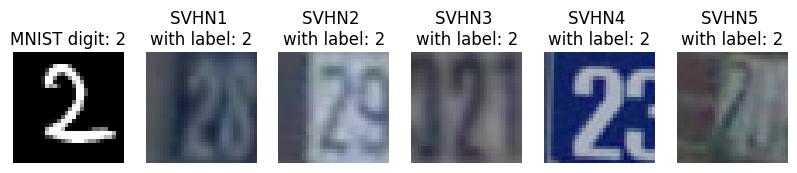

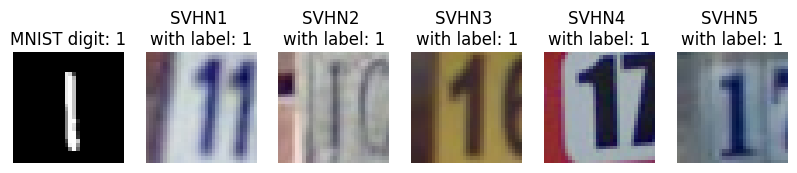

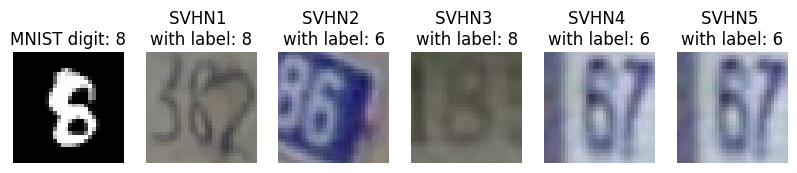

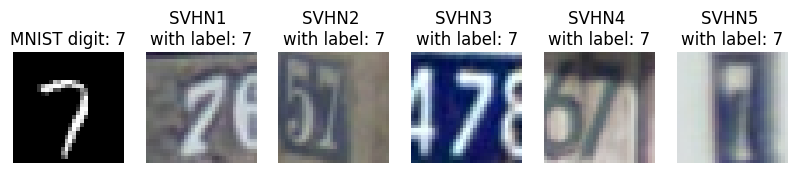

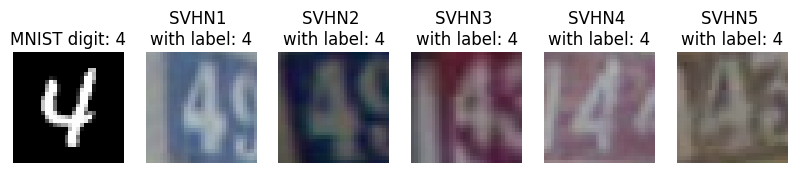

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Evaluation data, 100 
eval_mnist = [mnist_test[i] for i in torch.randint(0, len(mnist_test), (100,))]
eval_svhn = [svhn_train_1d[i] for i in torch.randint(0, len(svhn_train_1d), (2000,))]

# #show some eval svhn images
# fig = plt.figure(figsize=(10, 10))
# for i in range(10):
#     ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
#     ax.imshow(np.transpose(eval_svhn[i][0], (1, 2, 0))*0.5+0.5)
# plt.show()


# Compute embeddings
mnist_embeddings = model_mnist(torch.stack([x[0] for x in eval_mnist]).to(device)).cpu().detach().numpy()
svhn_embeddings = model_svhn(torch.stack([x[0] for x in eval_svhn]).to(device)).cpu().detach().numpy()

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(svhn_embeddings, [x[1] for x in eval_svhn])

#Predict the class of MNIST digits
pred = knn.predict(mnist_embeddings)

#Compute accuracy
acc = np.mean(pred == [x[1] for x in eval_mnist])

print("Accuracy: {:.2f}%".format(acc*100))

# Display the top 5 nearest SVHN neighbors for a few MNIST digits

num_mnist_to_display = 5

for i in range(num_mnist_to_display):
    mnists_digit = eval_mnist[i][0]
    mnists_digit_label = eval_mnist[i][1]
    mnist_embedding = mnist_embeddings[i]

    # Find the 5 nearest SVHN digit

    distances = np.linalg.norm(svhn_embeddings - mnist_embedding, axis=1)
    nearest_svhn_indices = np.argsort(distances)[:5]

    # Display the MNIST digit and the 5 nearest SVHN digits
    fig, axs = plt.subplots(1, 6, figsize=(10, 2))
    axs[0].imshow(mnists_digit.squeeze(), cmap='gray')
    axs[0].set_title("MNIST digit: {}".format(mnists_digit_label))
    axs[0].axis('off')

    for j, idx in enumerate(nearest_svhn_indices):
        svhn_digit = eval_svhn[idx][0]
        svhn_digit_label = eval_svhn[idx][1]
        axs[j+1].imshow(np.transpose(svhn_digit, (1, 2, 0)) * 0.5 + 0.5)
        axs[j+1].set_title(f'SVHN{j+1} \nwith label: {svhn_digit_label}')

        axs[j+1].axis('off')
    
    plt.show()

If you run into memory issues you can move your model to CPU to process the SVHN encodings.

**Question Grading** If you have trouble getting this to work you may still get partial credit for appropriate methodology. Grading for this question will be as follows:

10 points - appropriate triplet construction and loss function construction

10 points - appropriate nearest neighbor classification evaluation setup 

10 points - obtaining above 70% accuracy, 5 points for getting above 50%

10 points  - visualization of the retrieval

#### Unused code (Tried with my own sampling and decided to just use on the run instead)

In [ ]:
# import random
# def sample_triplets(anchor_set, positive_set, negative_set):
#     padding_layer = nn.ConstantPad2d(2, 0)
#     triplets = []

#     for anchor_label, anchor_img in zip(anchor_set[1], anchor_set[0]):
#         # Find positive samples
#         positive_indices = [i for i, positive_label in enumerate(positive_set[1]) if positive_label == anchor_label]
#         positive_img = positive_set[0][random.choice(positive_indices)]

#         # Find negative samples
#         negative_indices = [i for i, negative_label in enumerate(negative_set[1]) if negative_label != anchor_label]
#         negative_img = negative_set[0][random.choice(negative_indices)]

#         # Pad MNIST images if necessary
#         if anchor_img.shape[1] == 28:
#             anchor_img = padding_layer(anchor_img)
#         if positive_img.shape[1] == 28:
#             positive_img = padding_layer(positive_img)
#         if negative_img.shape[1] == 28:
#             negative_img = padding_layer(negative_img)

#         triplets.append((anchor_img, positive_img, negative_img))

#     return triplets

# Question 2

 In this Question we will experiment with a few publicly available generative models

# Warm-up Face interpolation (there is no question here and you can skip this section if you want)

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

c:\Users\x_zhu202\Documents\GitHub\COMP691_LABS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\x_zhu202/.cache\torch\hub\facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:

print(model.netG)

DataParallel(
  (module): GNet(
    (scaleLayers): ModuleList(
      (0): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (3): ModuleList(
        (0): EqualizedConv2d(
          (module): Con

We will visualize some randomly generated faces. Run this cell a few times to generate new faces

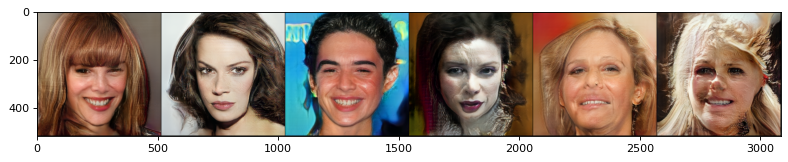

In [3]:
num_images = 6
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.netG(noise).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


In [4]:
print(noise.shape)
print(generated_images.shape)

torch.Size([6, 512])
torch.Size([6, 3, 512, 512])


Here we find two random faces images and their noise and writea function that will interpolate between two randomly generated faces. It will take a noise vector of size 2x512. Let's denote noise_1 and noise_2 the first and 2nd row. As above create 8 intermediate values that interpolate between them. 

e.g. if we had just one intermediate value we would end up with  noise_1, (noise_1+noise_2)/2, noise_2

we pass these through the generator (e.g. by putting them in a 8x512 noise tensor) and visualize the interpolation.

Note: again there is nothing to do here it is just an example to help you understand the next part

torch.Size([10, 512])
torch.Size([3, 1030, 4114])


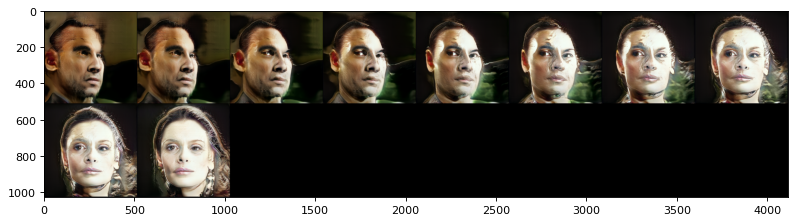

In [5]:
num_images = 2
noise, _ = model.buildNoiseData(num_images)
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]

noises = [noise[0]*a+noise[1]*(1.0-a) for a in alpha]
noises = torch.vstack(noises)
print(noises.shape)
with torch.no_grad():
    generated_images = model.netG(noises).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
print(grid.shape)

# Big-GAN interpolations (25 points)

2. We will now experiment with the bigGAN model trained on natural images. You can find the implementation and further documentation here https://github.com/huggingface/pytorch-pretrained-BigGAN. Run the cells below to download the model and generate some random images.

In [6]:
# !pip install pytorch-pretrained-biggan
# !pip install libsixel-python
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\x_zhu202\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import matplotlib.pyplot as plt
import torchvision


# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

We visualize the generated images

torch.Size([6, 128])
torch.Size([6, 1000])


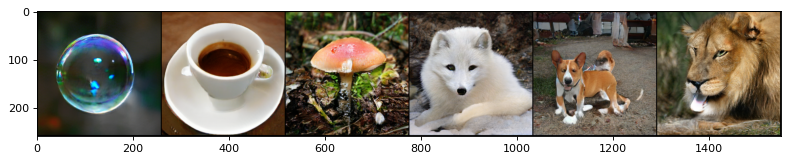

In [10]:
output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

Let's experiment with interpolating between different images in this model as we did in the face images. Note the BigGAN takes both a class vector and a random noise. 
(a) Sample two random images from the same category such as "dog" and interpolate between them with 8 intermediate steps and using the same class vector
(b) Sample two random images from two diff classes (e.g. "dog" and "mushroom") and interpolate between them. For the class conditionin variable you may interpolate between these as well for best results.

Feel free to try other combinations and categories.

Example of what your answer shoudl look like are below. however you should show it for a different images then the ones below (And different ones than your classmates :))

Same class interpolation of lion


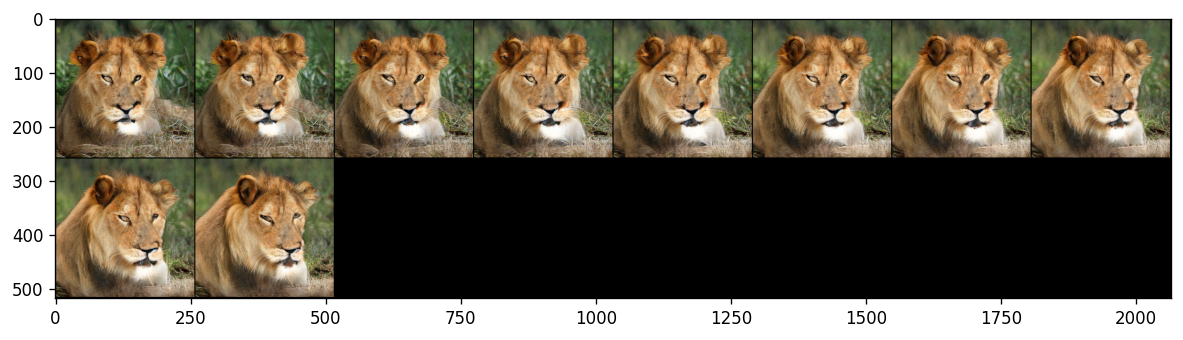

Diff class interpolation of soap bubble and coffee


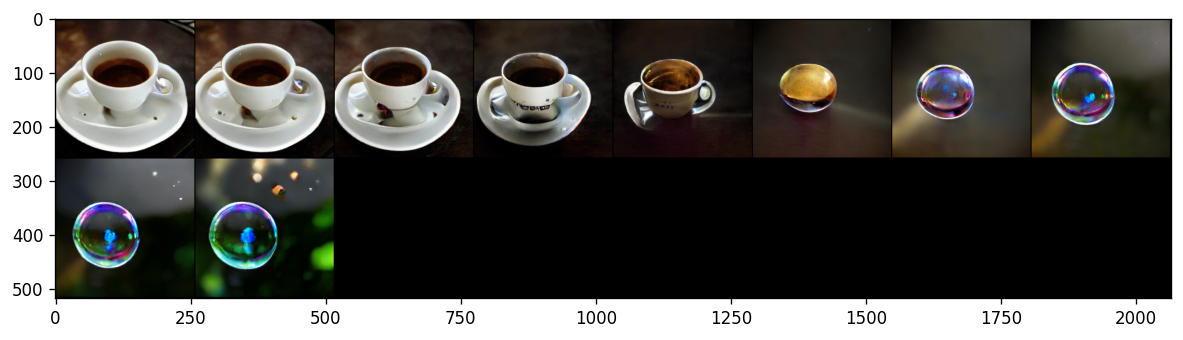

In [32]:
import numpy as np


def interpolate_image(class_name1, class_name2, noise1, noise2, num_interpolation =8):
    alpha_values = np.linspace(0, 1, num_interpolation+2)
    interpolated_noises = [noise1 * alpha + noise2 * (1 - alpha) for alpha in alpha_values]
    class1 = one_hot_from_names([class_name1])[0]
    class2 = one_hot_from_names([class_name2])[0]
    interpolated_classes = [class1 * alpha + class2 * (1 - alpha) for alpha in alpha_values]

    noise_tensor = torch.from_numpy(np.vstack(interpolated_noises)).to('cuda')
    class_tensor = torch.from_numpy(np.vstack(interpolated_classes)).to('cuda')
    
    # Generate an image
    with torch.no_grad():
        output = model(noise_tensor, class_tensor, truncation)
    
    # If you have a GPU put back on CPU
    return output.to('cpu')

def display_images(images):
    grid = torchvision.utils.make_grid(images.clamp(min=-1, max=1), scale_each=True, normalize=True)
    plt.figure(figsize=(12, 6), dpi=120)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

noise1_same_class = truncated_noise_sample(truncation=truncation, batch_size=1)
noise2_same_class = truncated_noise_sample(truncation=truncation, batch_size=1)
generated_images_same_class = interpolate_image('lion', 'lion', noise1_same_class, noise2_same_class)

noise1_diff_class = truncated_noise_sample(truncation=truncation, batch_size=1)
noise2_diff_class = truncated_noise_sample(truncation=truncation, batch_size=1)
generated_images_diff_class = interpolate_image('soap bubble', 'coffee', noise1_diff_class, noise2_diff_class)

print(f"Same class interpolation of lion")
display_images(generated_images_same_class)
print(f"Diff class interpolation of soap bubble and coffee")
display_images(generated_images_diff_class)


torch.Size([10, 128])
torch.Size([10, 1000])


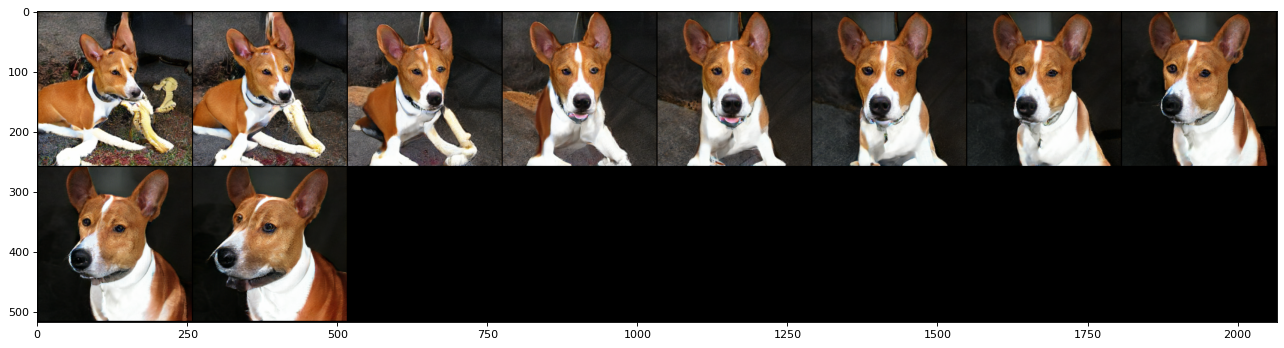

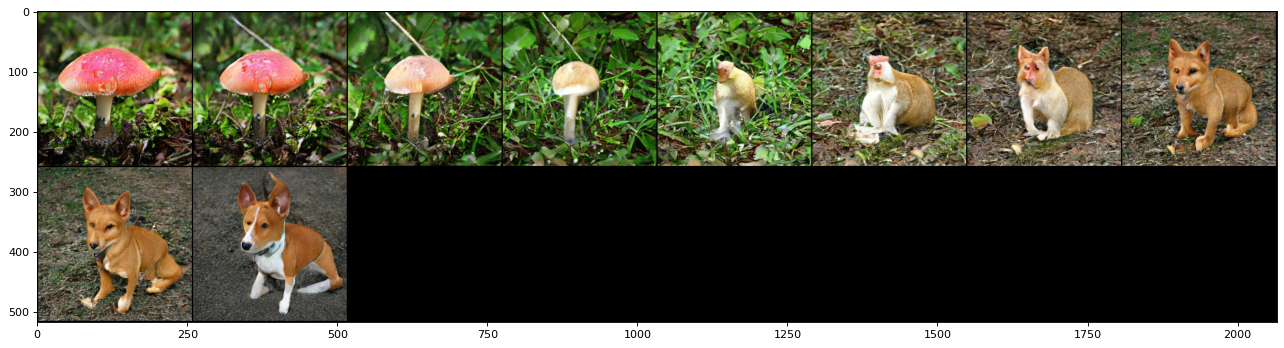

# Extra Credit Stable Diffusion Interpolations (8 points)

Experiment with the stable diffusion model (example notebook here https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). For two prompts of your choosing sample the images and also create interpolations between two images of your choice (as in the above questions) they can be images of the same and different prompts. 

### Solution 1 : HuggingFace already provides a (custom) interpolate pipeline

In [ ]:
from diffusers import DiffusionPipeline
import torch
import random

pipe = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    safety_checker=None,  # Very important for videos...lots of false positives while interpolating
    custom_pipeline="interpolate_stable_diffusion",
).to("cuda")
pipe.enable_attention_slicing()


random_integer1 = random.randint(1, 100)
random_integer2 = random.randint(1, 100)

frame_filepaths = pipe.walk(
    prompts=["a dog that is white and happy", "a dog that is black and unhappy"],
    seeds = [random_integer1,random_integer2],
    num_interpolation_steps=8,
    output_dir="./dreams",
    batch_size=4,
    height=512,
    width=512,
    guidance_scale=8.5,
    num_inference_steps=50,
)




Text(0.5, 1.0, 'Interpolation between two images of different prompts')

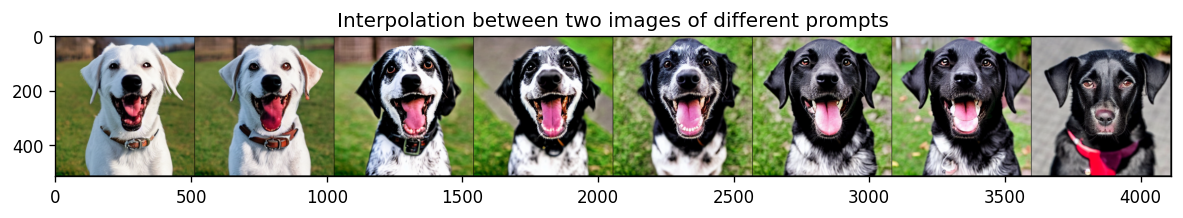

In [38]:
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from PIL import Image as PILImage
from IPython.display import Image, display
import numpy as np

image_tensors = [ToTensor()(PILImage.open(frame_filepath)) for frame_filepath in frame_filepaths]
grid = make_grid(image_tensors, scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=120)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title('Interpolation between two images of different prompts')

### Solution 2: Using the code from the example notebook

[Reference to stablediffusion interpolation tools](https://github.com/schmidtdominik/stablediffusion-interpolation-tools/blob/main/SD_interpolation.ipynb) 

Their code is not updated to the latest version of the model, so I did some modifications to make it work.

#### Dependencies

-  ```pip install imageio_ffmpeg opencv-python imageio```
- ```pip install transformers scipy ftfy accelerate```
- ```pip install diffusers['torch']```

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
import torch
from tqdm import tqdm, trange
from torch import autocast
from PIL import Image
import imageio
import numpy as np
from matplotlib import pyplot as plt
import inspect
import cv2
import pickle

device = 'cuda'

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [4]:
# compute embedding for single prompt
def prompt_to_text_emb(prompt):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        return text_encoder(text_input.input_ids.to(device))[0], text_input.input_ids.shape[-1]

In [15]:
# run generator starting from embedding
def generate(text_embeddings, max_length, height, width, num_inference_steps, guidance_scale, seed, batch_size):
    generator = torch.manual_seed(seed)
    
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]   
        
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(device)
    
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    #scheduler = PNDMScheduler()
    
    # set timesteps
    accepts_offset = "offset" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
    extra_set_kwargs = {}
    if accepts_offset:
        extra_set_kwargs["offset"] = 1

    scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
    
    # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
    if isinstance(scheduler, LMSDiscreteScheduler):
        latents = latents * scheduler.sigmas[0]

    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta
    
    
    with autocast("cuda"):
        for i, t in (enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            if isinstance(scheduler, LMSDiscreteScheduler):
                sigma = scheduler.sigmas[i]
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(scheduler, LMSDiscreteScheduler):
                latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]
            else:
                latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

            
    return latents

In [6]:
def decode_latents(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        return vae.decode(latents)

In [7]:
def interpolate_single_from_prompts(prompts, contin_ind):
    i1 = int(contin_ind)
    prompt1 = prompts[i1]
    emb1, max_length1 = prompt_to_text_emb(prompt1)
    if contin_ind == len(prompts)-1:
        return emb1, max_length1
    
    i2 = i1+1
    lerp = contin_ind-i1
    prompt2 = prompts[i2]
    emb2, max_length2 = prompt_to_text_emb(prompt2)
    assert max_length1 == max_length2
    
    return emb1*(1-lerp) + emb2*lerp, max_length1

In [17]:
def generate_e2e(i_contin, prompts, height, width, num_inference_steps, guidance_scale, seed):
    emb, max_length = interpolate_single_from_prompts(prompts, i_contin)
    latent = generate(
            text_embeddings=emb,
            max_length=max_length,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps, 
            guidance_scale=guidance_scale, 
            seed=seed,
            batch_size=1
        )
    image = decode_latents(latent)
    image = (image.sample / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [9]:
def n_imshow(*imgs, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(6*(len(imgs)-0.15), 6))
    for img, ax in zip(imgs, axes):
        ax.imshow(img, **kwargs)
    plt.show()

#### Generate images

100%|██████████| 2/2 [00:15<00:00,  8.00s/it]


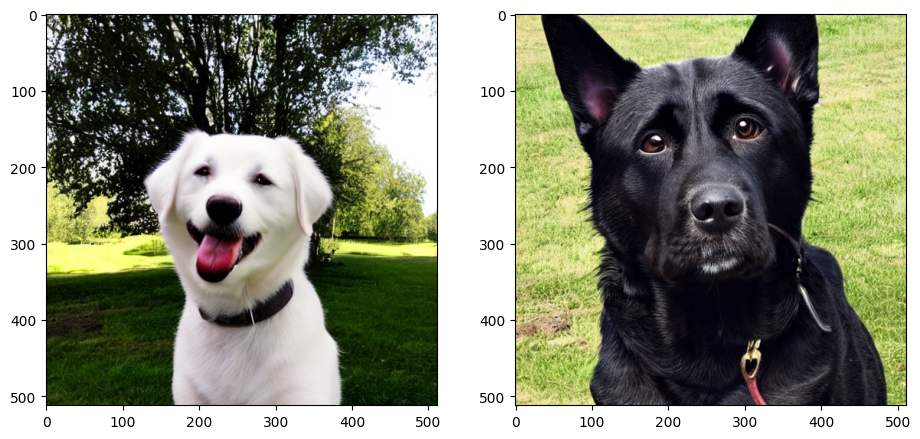

In [19]:
# generation settings

settings = dict(
    height=512,
    width=512,
    num_inference_steps=50,
    guidance_scale=7.5,
    seed=4,
)

prompts = [
    "a dog that is white and happy", "a dog that is black and unhappy"
]

w, h = settings['width'], settings['height']
result_contin_i = []
result_images = []

# generate 1 image for each prompt
for i in trange(len(prompts)):
    result_contin_i.append(i)
    result_images.append(generate_e2e(i, prompts, **settings))
n_imshow(*[np.array(img) for img in result_images])

#### Interpolation

100%|██████████| 1/1 [01:05<00:00, 65.11s/it]


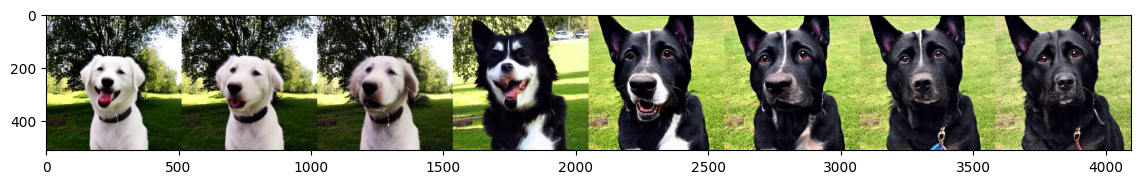

In [20]:
prompt_pairs = [
    [
        "a dog that is white and happy", "a dog that is black and unhappy"
    ]
]

n = 8 # how many interpolation steps
multistep_result = np.zeros((h*len(prompt_pairs), w*n, 3), dtype=np.uint8)

for r, prompt_pair in enumerate(tqdm(prompt_pairs)):
    for i, k in enumerate(np.linspace(0, 1, n)):
        result_img = generate_e2e(k, prompt_pair, **settings)
        multistep_result[r*h:(r+1)*h, i*w:(i+1)*w] = result_img
plt.figure(figsize=(14, 5))
plt.imshow(multistep_result)
plt.show()
imageio.imwrite('stablediff_multistep.png', multistep_result)